In [17]:
import re
import unicodedata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
# Plot aesthetics
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 120

# --- 1) Load ---
DATA_PATH = "student_feedback.csv"  
raw = pd.read_csv("student_feedback.csv")                  

In [19]:
# --- 2) Header hygiene & duplicate-column repair ---
def normalize_header(col: str) -> str:
    col = unicodedata.normalize("NFKD", str(col)).encode("ascii", "ignore").decode()
    col = col.strip()
    col = re.sub(r"\s+", " ", col)
    return col

raw.columns = [normalize_header(c) for c in raw.columns]

def uniquify_columns(cols):
    seen = {}
    new_cols = []
    for c in cols:
        if c not in seen:
            seen[c] = 0
            new_cols.append(c)
        else:
            seen[c] += 1
            new_cols.append(f"{c}__dup{seen[c]}")
    return new_cols

raw.columns = uniquify_columns(raw.columns)

drop_candidates = {"Unnamed: 0", "Student ID", "Timestamp", "Email Address"}
to_drop = [c for c in raw.columns if c in drop_candidates]
df = raw.drop(columns=to_drop) if to_drop else raw.copy()

before = len(df)
df = df.drop_duplicates()
after = len(df)

In [20]:

# --- 3) Identify text vs rating columns ---
FREE_TEXT_HINTS = ["open", "comment", "feedback", "suggestion", "improve", "what did"]
free_text_cols = [c for c in df.columns if any(h in c.lower() for h in FREE_TEXT_HINTS)]
likely_likert = [c for c in df.select_dtypes(include="object").columns if c not in free_text_cols]

In [21]:
# --- 4) Likert normalization ---
RATING_BASE = {
    "excellent": 5, "very good": 5, "good": 4, "average": 3,
    "fair": 2, "poor": 1, "very poor": 1, "bad": 1
}
DIFFICULTY_BASE = {
    "too easy": 1, "easy": 2, "average": 3, "difficult": 4, "very difficult": 5,
    "hard": 4, "very hard": 5
}
RECOMMEND_BASE = {
    "highly recommended": 5, "strongly recommend": 5,
    "recommended": 4, "recommend": 4,
    "neutral": 3,
    "not recommended": 2, "do not recommend": 2, "no": 2
}
ROUTING_RULES = [
    (re.compile(r"difficulty|assignment", re.I), DIFFICULTY_BASE),
    (re.compile(r"recommend|recommendation|nps|refer", re.I), RECOMMEND_BASE),
]

def clean_token(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode()
    s = re.sub(r"\s+", " ", s)
    return s

def choose_mapping(col_name):
    for pat, mapping in ROUTING_RULES:
        if pat.search(col_name):
            return mapping
    return RATING_BASE

encoded = df.copy()
applied_mappings = {}
for col in likely_likert:
    mapping = choose_mapping(col)
    applied_mappings[col] = mapping
    encoded[col] = encoded[col].map(clean_token).map(mapping)

In [23]:
# --- 5) Metrics ---
likert_only = encoded[likely_likert].select_dtypes(include=[np.number])
category_means = likert_only.mean(numeric_only=True).sort_values(ascending=False)
satisfaction_index = float(likert_only.stack().mean()) if not likert_only.empty else np.nan

rec_cols = [c for c in encoded.columns if re.search(r"recommend|recommendation|nps", c, re.I)]
def nps_on_1to5(s):
    s = s.dropna()
    if s.empty: return np.nan
    promoters = (s == 5).mean()
    detractors = (s <= 2).mean()
    return (promoters - detractors) * 100
nps_scores = {c: nps_on_1to5(encoded[c]) for c in rec_cols}
overall_nps = np.nanmean(list(nps_scores.values())) if nps_scores else np.nan


In [ ]:
# --- 6) Sentiment  ---
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

sentiment_df = pd.DataFrame()
if free_text_cols:
    melted = df[free_text_cols].melt(var_name="question", value_name="text").dropna()
    melted["sentiment"] = melted["text"].apply(lambda s: sia.polarity_scores(str(s))["compound"])
    sentiment_df = melted
avg_sentiment = float(sentiment_df["sentiment"].mean()) if not sentiment_df.empty else np.nan


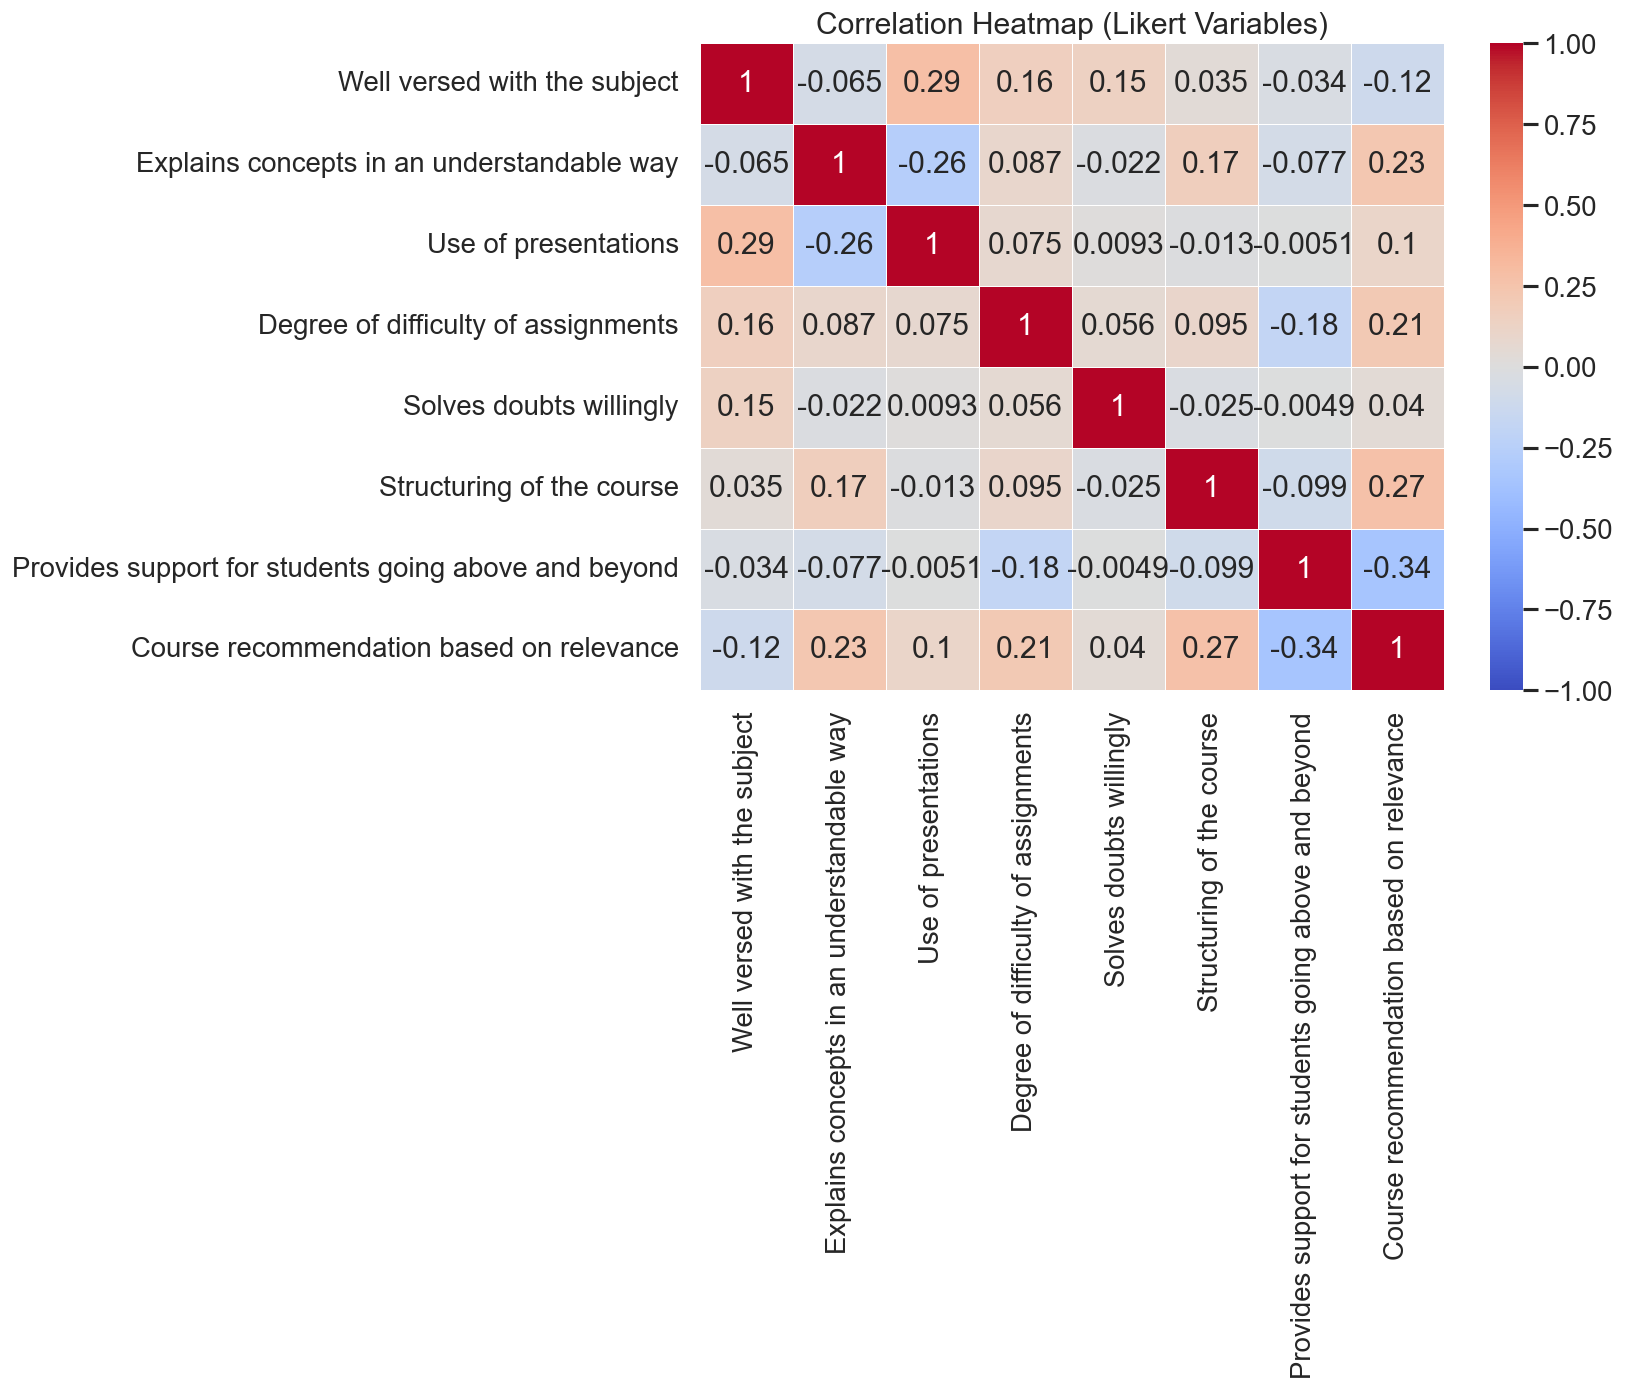

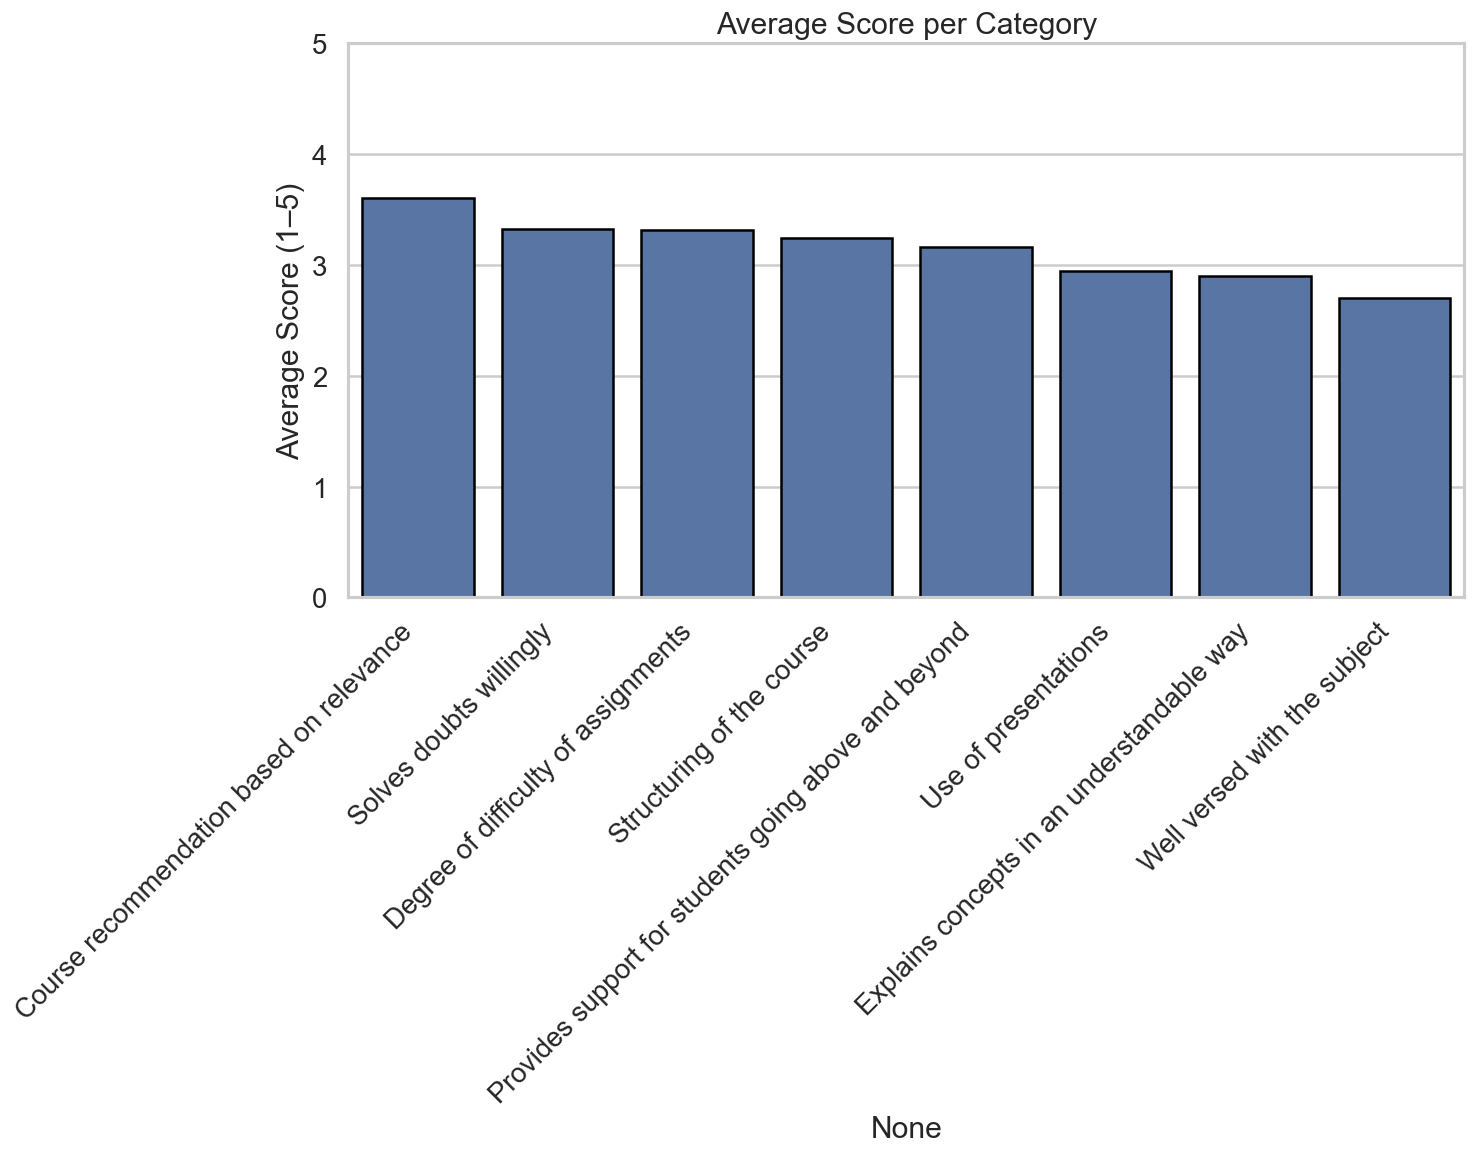

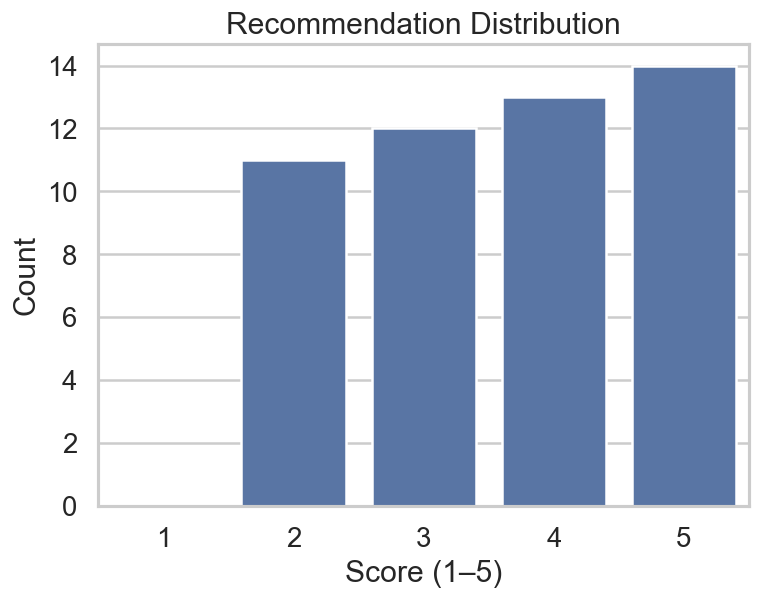

In [ ]:
# --- 7) Visualizations  ---
plt.figure(figsize=(10, 7))
sns.heatmap(likert_only.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap (Likert Variables)")
plt.show()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=category_means.index, y=category_means.values, edgecolor="black")
ax.set_ylim(0, 5)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Score (1–5)")
plt.title("Average Score per Category")
plt.show()

if rec_cols:
    plt.figure(figsize=(7, 5))
    stacked = pd.concat([encoded[c].rename(c) for c in rec_cols], axis=1).melt(value_name="score")
    sns.countplot(x="score", data=stacked, order=[1,2,3,4,5])
    plt.title("Recommendation Distribution")
    plt.xlabel("Score (1–5)")
    plt.ylabel("Count")
    plt.show()

if not sentiment_df.empty:
    plt.figure(figsize=(7,5))
    sns.histplot(sentiment_df["sentiment"], bins=25, kde=True)
    plt.title("Open-Ended Feedback Sentiment")
    plt.xlabel("Sentiment (-1 to +1)")
    plt.show()

In [27]:
# --- 8) Console Report ---
print("===== DATA QUALITY =====")
print(f"Rows before de-dupe: {before} | after: {after} | removed: {before - after}")
dupe_cols = [c for c in df.columns if "__dup" in c]
print(f"Duplicate columns fixed: {len(dupe_cols)} -> {dupe_cols if dupe_cols else 'None'}")

print("\n===== CORE METRICS =====")
print(f"Satisfaction Index (1-5): {round(satisfaction_index, 3)}")
print(f"Recommendation NPS (-100..100): {round(overall_nps, 1)}")
print(f"Average Sentiment (-1..1): {round(avg_sentiment, 3)}")

print("\n===== TOP & BOTTOM CATEGORIES =====")
print("Top 5:\n", category_means.head(5).to_string())
print("\nBottom 5:\n", category_means.tail(5).to_string())

if rec_cols:
    print("\n===== NPS by Recommendation Question =====")
    for k, v in nps_scores.items():
        print(f"{k}: {round(v, 1)}")

if not sentiment_df.empty:
    print("\n===== SENTIMENT SNAPSHOT =====")
    by_q = sentiment_df.groupby("question")["sentiment"].mean().sort_values(ascending=False)
    print("Avg sentiment by question:\n", by_q.round(3))
    print("Overall avg sentiment:", round(avg_sentiment, 3))


===== DATA QUALITY =====
Rows before de-dupe: 50 | after: 50 | removed: 0
Duplicate columns fixed: 0 -> None

===== CORE METRICS =====
Satisfaction Index (1-5): 3.14
Recommendation NPS (-100..100): 6.0
Average Sentiment (-1..1): nan

===== TOP & BOTTOM CATEGORIES =====
Top 5:
 Course recommendation based on relevance                3.600000
Solves doubts willingly                                 3.320000
Degree of difficulty of assignments                     3.314286
Structuring of the course                               3.240000
Provides support for students going above and beyond    3.160000

Bottom 5:
 Structuring of the course                               3.24
Provides support for students going above and beyond    3.16
Use of presentations                                    2.94
Explains concepts in an understandable way              2.90
Well versed with the subject                            2.70

===== NPS by Recommendation Question =====
Course recommendation based on relev